In [ ]:
import warnings
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import wandb
from tqdm import tqdm
import pandas as pd

entity_name = "geometric-governance"
# project_name = "strategic-voting-private"
# project_name = "strategic-voting-public"
project_name = "strategic-voting-results"
api = wandb.Api()

In [4]:
# Load robust training runs
runs = api.runs(path=f"{entity_name}/{project_name}")
runs_dict = defaultdict(lambda: defaultdict(lambda: defaultdict(list)))

for run in tqdm(runs):
    cfg = run.config

    history = run.history(
        keys=["val/welfare", "train/strategy_loss", "train/welfare_loss"]
    )

    mode = None
    election_model = cfg["election_model"]
    if election_model["from_pretrained"] == "default":
        if election_model["freeze_weights"]:
            mode = "standard-freeze"
        else:
            mode = "robust-train"
    elif election_model["from_pretrained"] == "robust":
        if election_model["freeze_weights"]:
            mode = "robust-freeze"

    if mode is None:
        warnings.warn("Unknown mode associated with cfg")
        continue

    history_dict = {
        "val/welfare": history["val/welfare"].to_numpy(),
        "train/strategy_loss": history["train/strategy_loss"].to_numpy(),
        "train/welfare_loss": history["train/welfare_loss"].to_numpy(),
    }

    runs_dict[cfg["vote_source"]][cfg["welfare_rule"]][mode].append(history_dict)


100%|██████████| 90/90 [00:26<00:00,  3.38it/s]


In [5]:
# Load best validation welfare
runs = api.runs(f"{entity_name}/maximise-welfare")

summary_list, config_list, name_list = [], [], []
for run in runs:
    summary_list.append(run.summary._json_dict)
    config_list.append({k: v for k, v in run.config.items() if not k.startswith("_")})
    name_list.append(run.name)

runs_df_raw = pd.DataFrame(
    {"summary": summary_list, "config": config_list, "name": name_list}
)
runs_df = runs_df_raw
runs_df["best_validation_welfare"] = runs_df["summary"].apply(
    lambda x: x["best_validation_welfare"]
)

honest_validation_welfare = runs_df.groupby("name")["best_validation_welfare"].max()


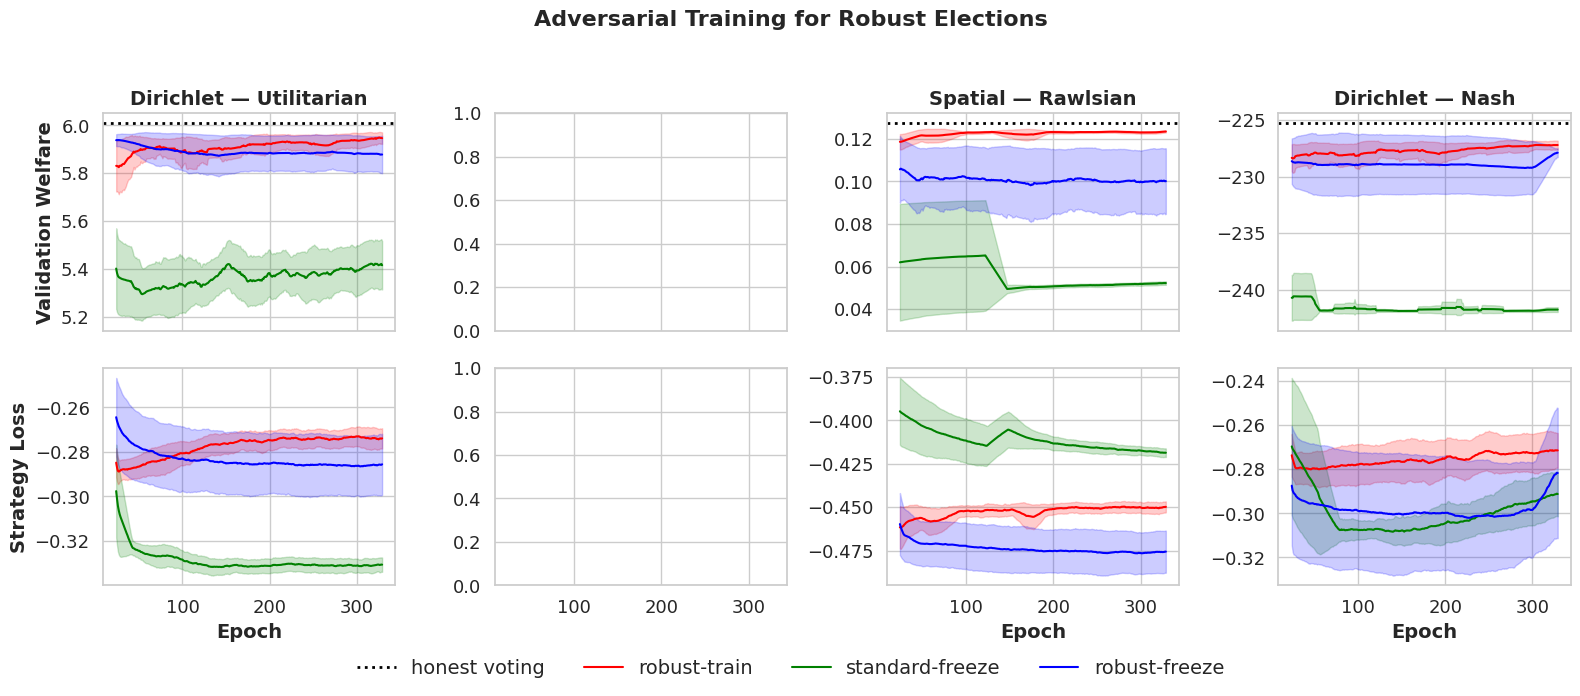

In [6]:
sns.set_theme(style="whitegrid")
plt.rcParams.update(
    {
        "font.size": 13,
        "axes.titlesize": 14,
        "axes.labelsize": 14,
        "legend.fontsize": 14,
        "xtick.labelsize": 13,
        "ytick.labelsize": 13,
        "font.sans-serif": ["DejaVu Sans"],
        "axes.labelweight": "bold",
    }
)


def moving_average(x, window_size):
    return np.convolve(x, np.ones(window_size), "valid") / window_size


def smooth_mean_and_se(arr, window_size):
    mean = moving_average(np.mean(arr, axis=0), window_size)
    stderr = moving_average(np.std(arr, axis=0) / np.sqrt(arr.shape[0]), window_size)
    return mean, 1.96 * stderr


def plot_selected_metrics(runs_dict, window_size: int = 25):
    colors = {
        "robust-freeze": "blue",
        "robust-train": "red",
        "standard-freeze": "green",
    }

    selected_pairs = [
        ("dirichlet", "utilitarian"),
        ("movielens", "utilitarian"),
        ("spatial", "rawlsian"),
        ("dirichlet", "nash"),
    ]

    n_rows, n_cols = 2, 4
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(16, 7), sharex=True)

    for col_idx, (vote_source, welfare_rule) in enumerate(selected_pairs):
        if vote_source not in runs_dict or welfare_rule not in runs_dict[vote_source]:
            continue

        ax_welfare = axs[0, col_idx]
        ax_loss = axs[1, col_idx]

        title = f"{vote_source} — {welfare_rule}".title()
        ax_welfare.set_title(title, fontsize=14, weight="bold", pad=6)

        honest_name = f"{vote_source}-utility-{welfare_rule}-welfare-small-sum"
        honest_welfare = honest_validation_welfare[honest_name]

        ax_welfare.axhline(
            y=honest_welfare,
            color="black",
            linestyle="dotted",
            linewidth=2.0,
            label="honest voting",
        )

        for mode, histories in runs_dict[vote_source][welfare_rule].items():
            if len(histories) == 0:
                continue

            welfare_curves = []
            strategy_loss_curves = []

            for hist in histories:
                val_welfare = hist["val/welfare"]
                strategy_loss = hist["train/strategy_loss"]
                min_len = min(len(val_welfare), len(strategy_loss))
                welfare_curves.append(val_welfare[:min_len])
                strategy_loss_curves.append(strategy_loss[:min_len])

            welfare_curves = np.stack(welfare_curves)
            strategy_loss_curves = np.stack(strategy_loss_curves)

            welfare_mean, welfare_se = smooth_mean_and_se(welfare_curves, window_size)
            loss_mean, loss_se = smooth_mean_and_se(strategy_loss_curves, window_size)
            x = np.arange(welfare_curves.shape[1])[window_size - 1 :]

            color = colors.get(mode, "gray")

            # Plot welfare
            ax_welfare.plot(x, welfare_mean, label=mode, color=color)
            ax_welfare.fill_between(
                x,
                welfare_mean - welfare_se,
                welfare_mean + welfare_se,
                color=color,
                alpha=0.2,
            )

            # Plot strategy loss
            ax_loss.plot(x, loss_mean, label=mode, color=color)
            ax_loss.fill_between(
                x, loss_mean - loss_se, loss_mean + loss_se, color=color, alpha=0.2
            )

        if col_idx == 0:
            ax_loss.set_ylabel("Strategy Loss")
            ax_welfare.set_ylabel("Validation Welfare")
        ax_loss.set_xlabel("Epoch")

    fig.suptitle(
        "Adversarial Training for Robust Elections",
        fontsize=16,
        weight="bold",
        y=0.98,  # <-- Moves the title closer to the plots
    )

    # Shared legend to the right
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.0),
        ncol=len(labels),
        frameon=False,
        fontsize=14,
    )

    plt.tight_layout(rect=[0.0, 0.05, 1.0, 0.95])
    fig.savefig(f"{project_name}-adversarial_training_plot.png", format="png")
    plt.show()


plot_selected_metrics(runs_dict)

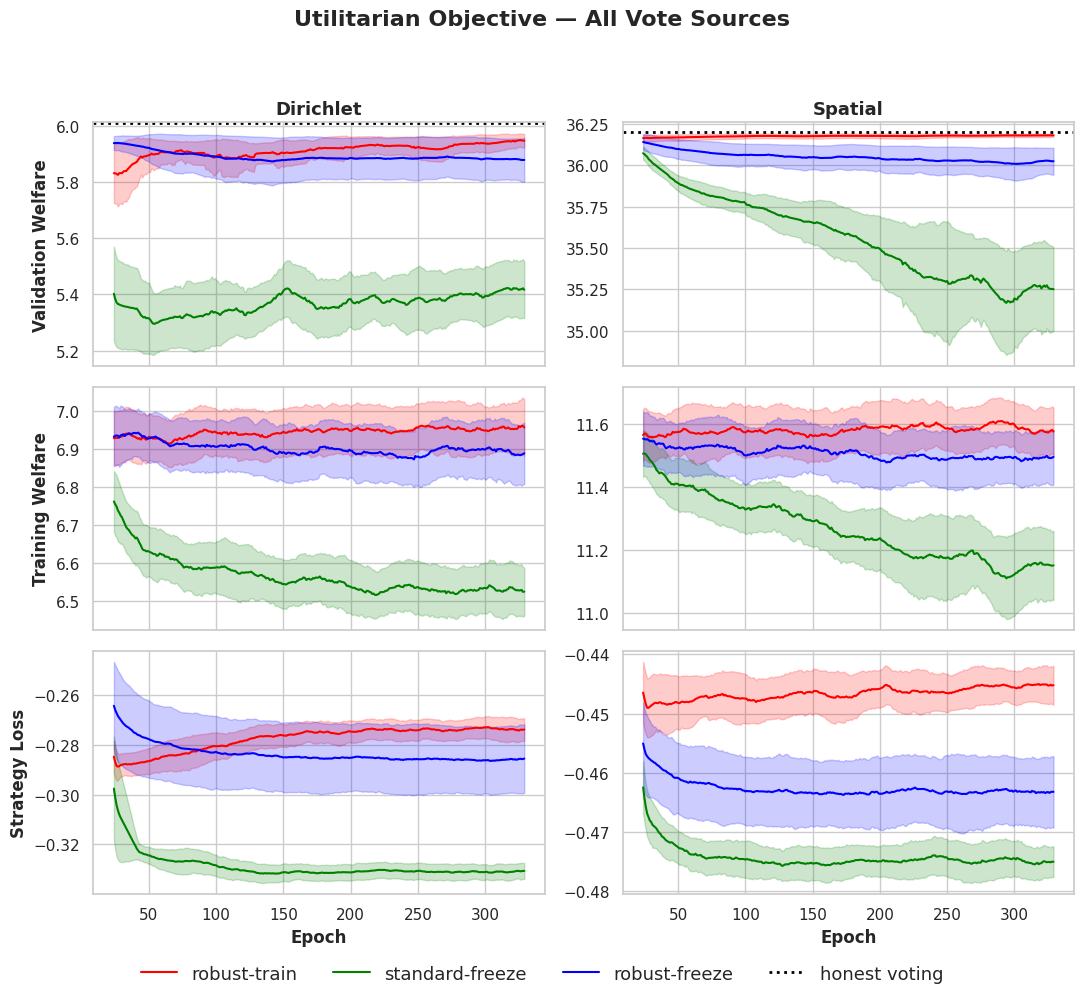

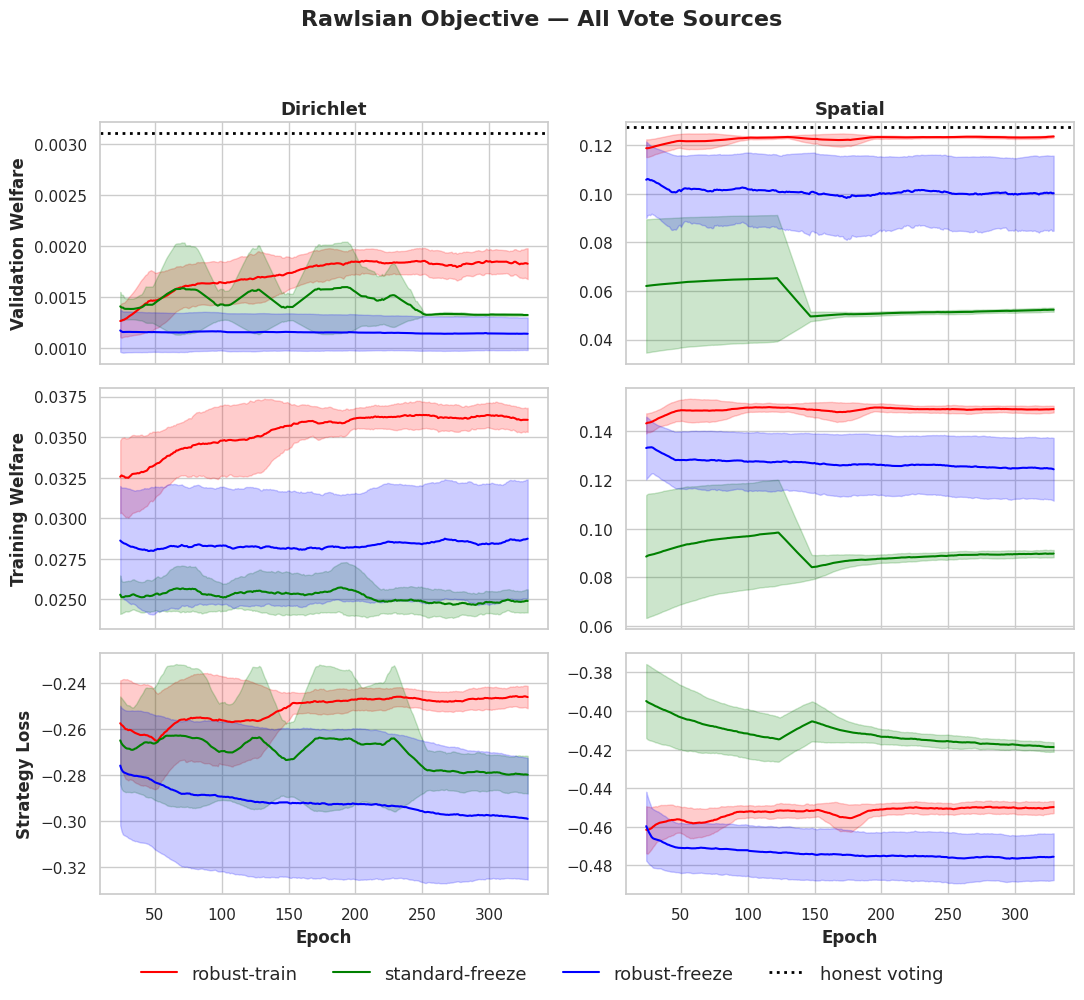

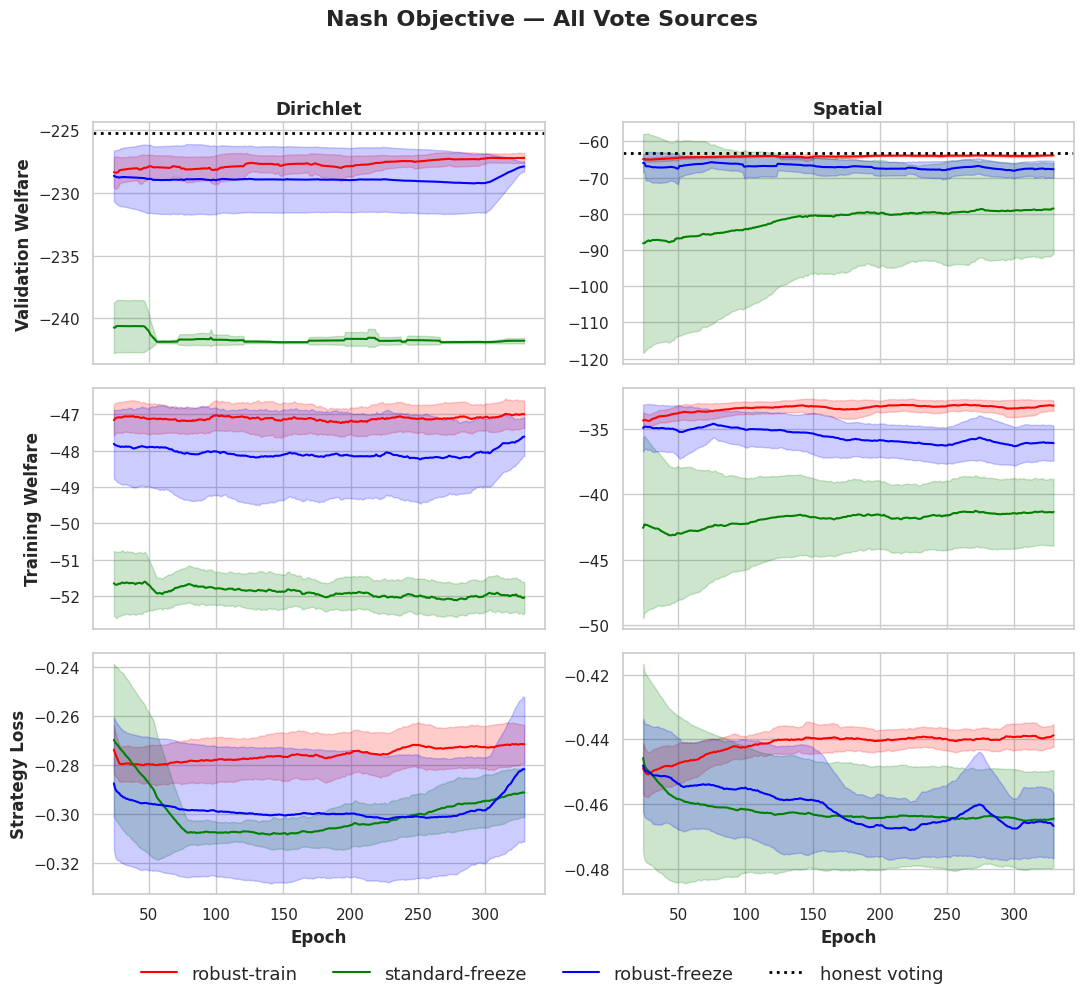

In [7]:
sns.set_theme(style="whitegrid")


def plot_by_welfare_rule(runs_dict, welfare_rule, window_size=25):
    colors = {
        "robust-freeze": "blue",
        "robust-train": "red",
        "standard-freeze": "green",
    }

    vote_sources = sorted([vs for vs in runs_dict if welfare_rule in runs_dict[vs]])
    n_cols = len(vote_sources)

    fig, axs = plt.subplots(3, n_cols, figsize=(5.5 * n_cols, 10), sharex=True)
    fig.suptitle(
        f"{welfare_rule.title()} Objective — All Vote Sources",
        fontsize=16,
        weight="bold",
        y=0.995,
    )

    for col_idx, vote_source in enumerate(vote_sources):
        if welfare_rule not in runs_dict[vote_source]:
            continue

        data = runs_dict[vote_source][welfare_rule]

        for mode, histories in data.items():
            if not histories:
                continue

            val_welfare_curves = []
            train_welfare_curves = []
            strategy_loss_curves = []

            for hist in histories:
                val_welfare = hist["val/welfare"]
                train_welfare = [-v for v in hist["train/welfare_loss"]]
                strategy_loss = hist["train/strategy_loss"]
                min_len = min(len(val_welfare), len(train_welfare), len(strategy_loss))

                val_welfare_curves.append(val_welfare[:min_len])
                train_welfare_curves.append(train_welfare[:min_len])
                strategy_loss_curves.append(strategy_loss[:min_len])

            val_welfare_curves = np.stack(val_welfare_curves)
            train_welfare_curves = np.stack(train_welfare_curves)
            strategy_loss_curves = np.stack(strategy_loss_curves)

            x = np.arange(val_welfare_curves.shape[1])[window_size - 1 :]
            color = colors.get(mode, "gray")

            # Validation welfare
            mean, se = smooth_mean_and_se(val_welfare_curves, window_size)
            axs[0, col_idx].plot(x, mean, label=mode, color=color)
            axs[0, col_idx].fill_between(
                x, mean - se, mean + se, color=color, alpha=0.2
            )

            # Training welfare
            mean, se = smooth_mean_and_se(train_welfare_curves, window_size)
            axs[1, col_idx].plot(x, mean, label=mode, color=color)
            axs[1, col_idx].fill_between(
                x, mean - se, mean + se, color=color, alpha=0.2
            )

            # Strategy loss
            mean, se = smooth_mean_and_se(strategy_loss_curves, window_size)
            axs[2, col_idx].plot(x, mean, label=mode, color=color)
            axs[2, col_idx].fill_between(
                x, mean - se, mean + se, color=color, alpha=0.2
            )

        # Honest baselines
        honest_key = f"{vote_source}-utility-{welfare_rule}-welfare-small-sum"
        if honest_key in honest_validation_welfare:
            axs[0, col_idx].axhline(
                honest_validation_welfare[honest_key],
                color="black",
                linestyle="dotted",
                linewidth=2,
                label="honest voting",
            )

        for row_idx, ax in enumerate(axs[:, col_idx]):
            if col_idx == 0:
                ylabel = ["Validation Welfare", "Training Welfare", "Strategy Loss"][
                    row_idx
                ]
                ax.set_ylabel(ylabel)
            if row_idx == 2:
                ax.set_xlabel("Epoch")
            if row_idx == 0:
                ax.set_title(vote_source.title(), fontsize=13, weight="bold")

    # Shared legend
    handles, labels = axs[0, 0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        loc="lower center",
        bbox_to_anchor=(0.5, 0.005),
        ncol=len(labels),
        frameon=False,
        fontsize=13,
    )

    plt.tight_layout(rect=[0, 0.04, 1, 0.96])
    fig.savefig(f"{project_name}_{welfare_rule.lower()}_overview.png", format="png")
    plt.show()


# === Generate plots per welfare rule ===

for rule in ["utilitarian", "rawlsian", "nash"]:
    plot_by_welfare_rule(runs_dict, welfare_rule=rule)
